# Class Workbook {.tabset .tabset-fade .tabset-pills}

In [29]:
import numpy as np
from scipy.special import expit
import pandas as pd
import seaborn as sns
import math
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from plotnine import *
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import patchworklib as pw
from mpl_toolkits.mplot3d import Axes3D

#import ISLP as islp

## In class activity

### COVID-19 Survival in Mexico

Your task is determining whether a patient will survive COVID-19 in Mexico.
The original dataset comes from the [Mexican government](https://datos.gob.mx/busca/dataset/informacion-referente-a-casos-covid-19-en-mexico).  This data is a version downloaded from [Kaggle](https://www.kaggle.com/datasets/meirnizri/covid19-dataset?resource=download).  The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

- sex: 1 for female and 2 for male.
- age: of the patient.
- classification: COVID test findings. Values 1-3 mean that the patient was diagnosed with COVID in different degrees. 4 or higher means that the patient is not a carrier of COVID or that the test is inconclusive.
- patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
- pneumonia: whether the patient already have air sacs inflammation or not.
- pregnancy: whether the patient is pregnant or not.
- diabetes: whether the patient has diabetes or not.
- copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
- asthma: whether the patient has asthma or not.
- inmsupr: whether the patient is immunosuppressed or not.
- hypertension: whether the patient has hypertension or not.
- cardiovascular: whether the patient has heart or blood vessels related disease.
- renal chronic: whether the patient has chronic renal disease or not.
- other disease: whether the patient has other disease or not.
- obesity: whether the patient is obese or not.
- tobacco: whether the patient is a tobacco user.
- usmr: Indicates whether the patient treated medical units of the first, second or third level.
- medical unit: type of institution of the National Health System that provided the care.
- intubed: whether the patient was connected to the ventilator.
- icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
- date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.

In [30]:
Covid_Data= pd.read_csv("Covid_Data.csv")

Creating survival variable

In [31]:
Covid_Data['SURVIVED'] = Covid_Data['DATE_DIED'].apply(lambda x: 0 if x !="9999-99-99" else 1)


Gender Factoring

In [32]:
#Covid_Data$SEX = factor(Covid_Data$SEX ,levels=c(1,2),labels=c("female","male"))
#Covid_Data$FEMALE = 1*(Covid_Data$SEX==1)
gender = [1,2]
female= [1,0]

Covid_Data['FEMALE'] = Covid_Data['SEX'].replace(gender, female)

Missing data are coded as 99 or 97, we need to change them to NA.  However we need to know which variable to do so before making the change.

In [33]:
Covid_Data_99=Covid_Data==99
Covid_Data_99.sum(axis=0)
Covid_Data_97=Covid_Data==97
Covid_Data_97.sum(axis=0)

## Recode missing data as NA ##
Covid_Data.loc[Covid_Data.INTUBED >=3, 'INTUBED'] = None
Covid_Data.loc[Covid_Data.PNEUMONIA >=3, 'PNEUMONIA'] = None
Covid_Data.loc[Covid_Data.PREGNANT>=3, 'PREGNANT'] = None
Covid_Data.loc[Covid_Data.ICU  >=3, 'ICU'] = None

## Factor the variables

levels = [1,2]
yesno = [1,0]

Covid_Data['INTUBED'] = Covid_Data['INTUBED'].replace(levels, yesno)
Covid_Data['PNEUMONIA'] = Covid_Data['PNEUMONIA'].replace(levels, yesno)
Covid_Data['PREGNANT'] = Covid_Data['PREGNANT'].replace(levels, yesno)
Covid_Data['ICU'] = Covid_Data['ICU'].replace(levels, yesno)

#Covid_Data$PREGNANT[Covid_Data$FEMALE == 0 & is.na(Covid_Data$PREGNANT)] ="no"
Covid_Data.loc[Covid_Data.FEMALE ==0 &Covid_Data['PREGNANT'].isnull(), 'PREGNANT'] = 0

In [34]:
Covid_Data.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,SURVIVED,FEMALE
0,2,1,1,1,03/05/2020,NaN,1.0,65,0.0,2,...,1,2,2,2,2,2,3,NaN,0,1
1,2,1,2,1,03/06/2020,NaN,1.0,72,0.0,2,...,1,2,2,1,1,2,5,NaN,0,0
2,2,1,2,2,09/06/2020,1.0,0.0,55,0.0,1,...,2,2,2,2,2,2,3,0.0,0,0
3,2,1,1,1,12/06/2020,NaN,0.0,53,0.0,2,...,2,2,2,2,2,2,7,NaN,0,1
4,2,1,2,1,21/06/2020,NaN,0.0,68,0.0,1,...,1,2,2,2,2,2,3,NaN,0,0


### Looking at AGE

You can see a clear trend by age.

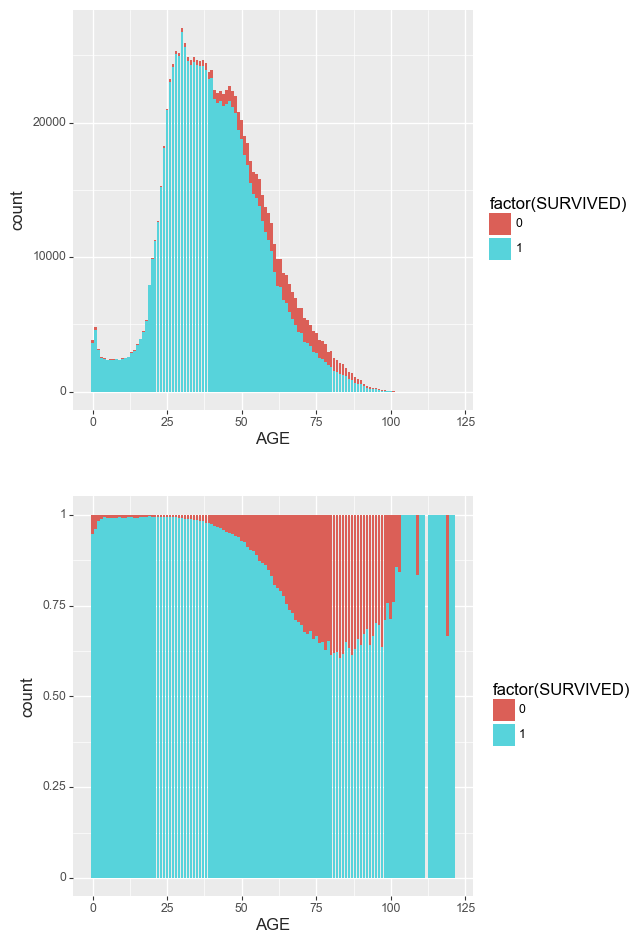

In [35]:
g = (
ggplot(Covid_Data)+geom_bar()+aes(x="AGE",fill="factor(SURVIVED)")
)
g1 = pw.load_ggplot(g, figsize=(4,4))

g = (
ggplot(Covid_Data)+geom_bar(position="fill")+aes(x="AGE",fill="factor(SURVIVED)")
)
g2 = pw.load_ggplot(g, figsize=(4,4))

g12 = (g1/g2)
g12.savefig("./Ch04_Classification_Python_files/figure-html/multiplots.png")

#table(Covid_Data$AGE)

![fig](Images/multiplots.png)

Since there are very few people above 100, we will look at people above 100 as 100.  This is to make our problem easier, but it also tries to address the limit of what we can say.

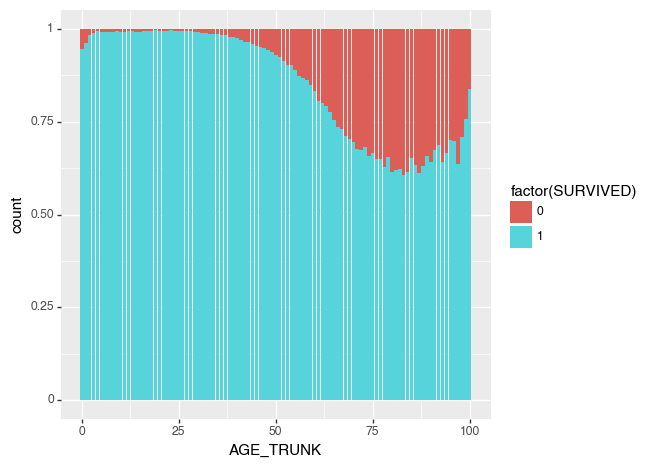

<Figure Size: (640 x 480)>

In [10]:
Covid_Data['AGE_TRUNK'] = Covid_Data['AGE']
Covid_Data.loc[Covid_Data.AGE_TRUNK >100, 'AGE_TRUNK'] = 100
(
ggplot(Covid_Data)+geom_bar(position="fill")+aes(x="AGE_TRUNK",fill="factor(SURVIVED)")
)

### Looking at Gender

Distribution by gender and age shows differing rate for male and female that needs to be accounted for.

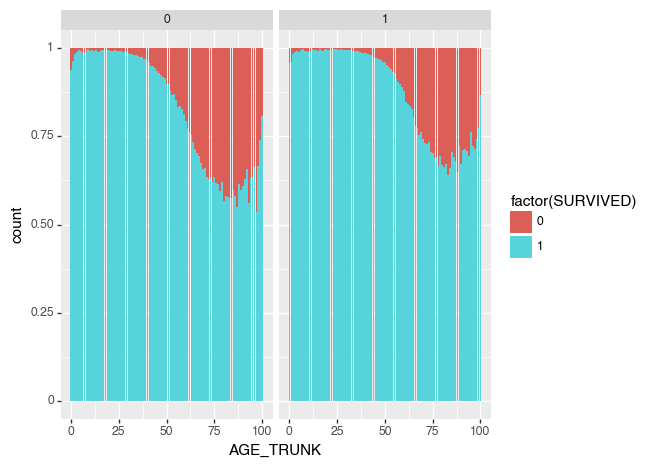

<Figure Size: (640 x 480)>

In [11]:
(

ggplot(Covid_Data)+geom_bar(position="fill")+aes(x="AGE_TRUNK",fill="factor(SURVIVED)")
+facet_wrap("~FEMALE")

)

### An initial look.

We fit a model with age and gender.

In [12]:
#Covid_Data$SURVIVED_bin =1*(Covid_Data$SURVIVED=="yes")
glm_fit= sm.logit("SURVIVED~AGE_TRUNK*FEMALE",data= Covid_Data).fit()
glm_fit.converged

Optimization terminated successfully.
         Current function value: 0.208783
         Iterations 8


True

the model converges.

In [13]:
glm_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               SURVIVED   No. Observations:              1048575
Model:                          Logit   Df Residuals:                  1048571
Method:                           MLE   Df Model:                            3
Date:                Tue, 30 Jan 2024   Pseudo R-squ.:                  0.2040
Time:                        21:34:43   Log-Likelihood:            -2.1892e+05
converged:                       True   LL-Null:                   -2.7503e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.9051      0.019    305.636      0.000       5.867       5.943
AGE_TRUNK           -0.0725      0.000   -221.107      0.000      -0.073      -0.072
FEMALE               0.9911      0.032     31.153      0.000       0.929       1.054
AGE_TRUNK:FEMALE    -0.0060      0.001    -11.436      0.000      -0.007      -0.005
====================================================================================
"""

Confusion matrix with a cutoff of 0.5 looks like

In [14]:
logit_P = glm_fit.predict(Covid_Data)#,type="response"
logit_Pred = np.where(logit_P > 0.5, 1, 0) # Probability check
#CM= table(Covid_Data$SURVIVED_bin, logit_Pred)
#print(CM)
# Using confusion_matrix

cf_mat = confusion_matrix(Covid_Data['SURVIVED'], logit_Pred)
print('Confusion matrix')
print(cf_mat)
# Using crosstab
pd.crosstab(Covid_Data['SURVIVED'], logit_Pred).stack().reset_index(name='Freq')

Confusion matrix
[[  4340  72602]
 [  7094 964539]]


,SURVIVED,col_0,Freq
0,0,0,4340
1,0,1,72602
2,1,0,7094
3,1,1,964539


The ROC Curve looks like

model 1 AUC score: 0.5245525067444773


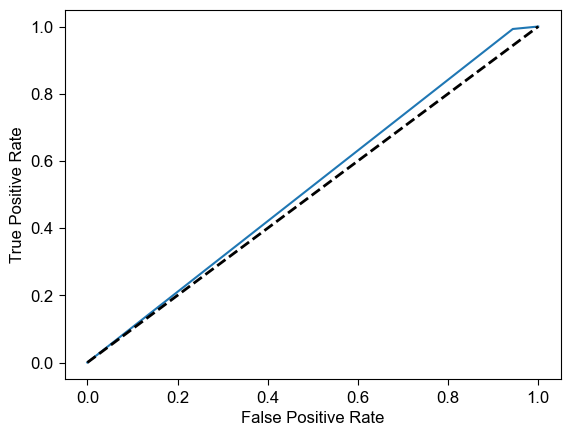

In [15]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color = 'black', linestyle='--',linewidth = 2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


plot_roc_curve(Covid_Data['SURVIVED'], logit_Pred)
print(f'model 1 AUC score: {roc_auc_score(Covid_Data.SURVIVED, logit_Pred)}')

It seems to be doing fairly well.

Let's look at a decile plot.  Decile plot looks at prediction accuracy by the predicted probability.  Since seeing the lower probability is easier, we will look at the predicted death probability.  You can read about Decile plots here: (https://select-statistics.co.uk/blog/cumulative-gains-and-lift-curves-measuring-the-performance-of-a-marketing-campaign/)

   Decile    Actual      Lift
0       0  0.321657  4.383579
1       1  0.169735  2.313169
2       2  0.090321  1.230900
3       3  0.053762  0.732673
4       4  0.031719  0.432276
5       5  0.020242  0.275864
6       6  0.012893  0.175714
7       7  0.008238  0.112271
8       8  0.005896  0.080358
9       9  0.009940  0.135459


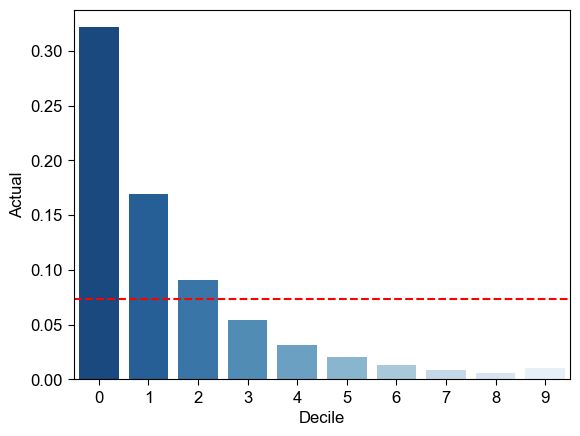

In [16]:
plt.clf()
#plot_lift_curve(Covid_Data['SURVIVED'], logit_Pred)
revP =1-logit_P
results = pd.DataFrame({'Actual': 1-Covid_Data['SURVIVED'], 'Predicted': logit_Pred, 'Probability': logit_P})

# Creating Deciles
results['Decile'] = pd.qcut(results['Probability'], q=10, labels=False)

# Calculate the response rate for each decile
decile_stats = results.groupby('Decile')['Actual'].mean().reset_index()

# Calculate the average response rate
average_response_rate = results['Actual'].mean()

# Calculate the lift for each decile
decile_stats['Lift'] = decile_stats['Actual'] / average_response_rate

# Print the decile statistics
print(decile_stats)

ax=sns.barplot(x = "Decile", y = "Actual", data = decile_stats, order = range(0, 10),
palette = 'Blues_r')
ax.axhline(y = 1-Covid_Data['SURVIVED'].mean(), xmin = 0, xmax = 10,
           color = "red", linestyle = "dashed")
plt.show()

This plot shows that the model does capture the riskiest patients well in the first three bins.

However, when you look at the residual, there are clear signs that the model does not fit very well.

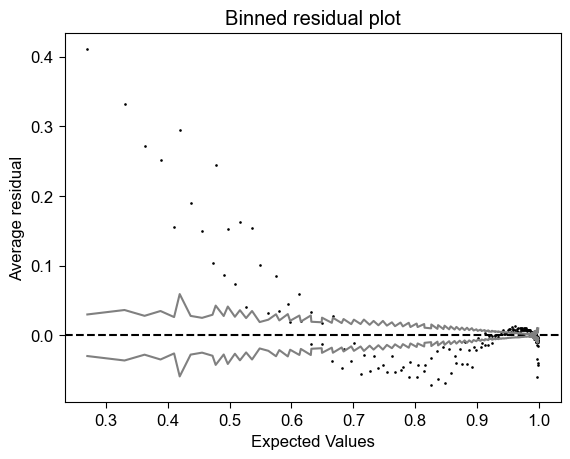

In [17]:
def binned_resids(x, y, nclass=None):
    if nclass is None:
        nclass = int(np.floor(np.sqrt(len(x))))

    breaks_index = np.floor(np.arange(1, nclass) * len(x) / nclass).astype(int)
    if any(breaks_index == 0):
        nclass = 1

    x_sort = np.sort(x)
    breaks = np.array([-np.inf])
    if nclass > 1:
        for i in range(nclass - 1):
            x_lo = x_sort[breaks_index[i]]
            x_hi = x_sort[breaks_index[i] + 1]

            if x_lo == x_hi:
                if x_lo == np.min(x):
                    x_lo = -np.inf
                else:
                    x_lo = np.max(x[x < x_lo])

            breaks = np.concatenate((breaks, [(x_lo + x_hi) / 2]))

    elif nclass == 1:
        x_lo = np.min(x)
        x_hi = np.max(x)
        breaks = np.concatenate((breaks, [(x_lo + x_hi) / 2]))

    breaks = np.concatenate((breaks, [np.inf]))
    breaks = np.unique(breaks)
    nclass = len(breaks) - 1

    output = []
    x_binned = pd.cut(x, breaks).codes + 1

    for i in range(1, nclass + 1):
        items = np.where(x_binned == i)[0]
        x_range = [np.min(x[items]), np.max(x[items])]
        x_bar = np.mean(x[items])
        y_bar = np.mean(y[items])
        n = len(items)
        sdev = np.std(y[items]) if len(y[items]) > 1 else 0

        output.append([x_bar, y_bar, n, x_range[0], x_range[1], 2 * sdev / np.sqrt(n)])

    colnames = ["xbar", "ybar", "n", "x.lo", "x.hi", "2se"]
    output_df = pd.DataFrame(output, columns=colnames)

    return {"binned": output_df, "xbreaks": None}

def binnedplot(x, y, nclass=None, xlab="Expected Values", ylab="Average residual",
               main="Binned residual plot", cex_pts=0.8, col_pts="black",
               col_int="gray", **kwargs):
    n = len(x)

    if nclass is None:
        if n >= 100:
            nclass = int(np.floor(np.sqrt(len(x))))
        elif 10 < n < 100:
            nclass = 10
        elif n <= 10:
            nclass = int(np.floor(n / 2))

    binned_resids_result = binned_resids(x, y, nclass)
    aa = pd.DataFrame(binned_resids_result['binned'])

    plt.plot([np.min(aa['xbar']), np.max(aa['xbar'])],
             [np.min(aa[['ybar', '2se']].values), np.max(aa[['ybar', '2se']].values)],alpha=0,
              **kwargs)
    #xlab=xlab, ylab=ylab,  main=main,
    plt.axhline(0, linestyle='dashed', color='black')
    plt.title(main)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.plot(aa['xbar'], aa['2se'], color=col_int)
    plt.plot(aa['xbar'], -aa['2se'], color=col_int)

    plt.scatter(aa['xbar'], aa['ybar'], marker='o', s=cex_pts, color=col_pts)

    plt.show()

plt.clf()
binnedplot(glm_fit.predict(),glm_fit.resid_response)

The model is not capturing the lower-risk patients; there is nonlinearity, and the very high-risk patients have some problems, too.  Given the EDA plots we've seen so far, these should not be a surprise.  So, what can we do to improve the performance of the model?

### In-class activity

Your goal is to use 30% of the patients as your training data and predict the outcome of the remaining patients.  It's important to note that you also need to get a prediction for patients with NA values.

In [28]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(Covid_Data.loc[:,Covid_Data.columns != "SURVIVED"], Covid_Data.loc[:,"SURVIVED"], test_size=0.33, random_state=42)

Train_COVID = pd.concat([X_train, y_train], axis=1)
Test_COVID = pd.concat([X_test, y_test], axis=1)

compression_opts = dict(method='zip',
                        archive_name='Train_COVID.csv')
Train_COVID.to_csv('Train_COVID.zip', index=False,
          compression=compression_opts)
compression_opts2 = dict(method='zip',
                        archive_name='Test_COVID.csv')
Test_COVID.to_csv('Test_COVID.zip', index=False,
          compression=compression_opts2)
Test_COVID.to_csv('Train_COVID.csv')
# Sanity check
y_train.mean()
y_test.mean()

0.927457156893911

Q1. What metric will you use? Why?

Your code:

In [36]:
#
#
from sklearn.metrics import confusion_matrix

def specificity_calculation(y_pred, y_true):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

Q2. What was your best performing model?

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

Q3. Explain how you got the model in detail.


Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

Q4. Based on your model, what factor seems to be important in deciding if a patient survives or not.

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

## Problem Set

### Auto Data

In this problem, you will develop a model to predict whether a given car gets high or low gas mileage based on the `Auto` data set.

(a) Create a binary variable, mpg01, that contains a 1 if mpg contains
a value above its median, and a 0 if mpg contains a value below
its median. You can compute the median using the median()
method of the data frame. Note you may find it helpful to add
a column mpg01 to the data frame by assignment. Assuming you
have stored the data frame as Auto, this can be done as follows:

In [ ]:
#Auto['mpg01'] = mpg01

Your code:

In [19]:
#
#
auto_data = pd.read_csv("Auto.csv")
mpg_median = auto_data['mpg'].median()

# Create the binary variable 'mpg01'
auto_data['mpg01'] = (auto_data['mpg'] > mpg_median).astype(int)

# Display the first few rows of the modified dataframe
auto_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,0
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,0
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,0
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,0
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,0


Your answer:

~~~
Please write your answer in full sentences.


~~~


(b) Explore the data graphically in order to investigate the association
between mpg01 and the other features. Which of the other
features seem most likely to be useful in predicting mpg01? Scatterplots
and boxplots may be useful tools to answer this question.
Describe your findings.

(c) Split the data into a training set and a test set.

Your code:

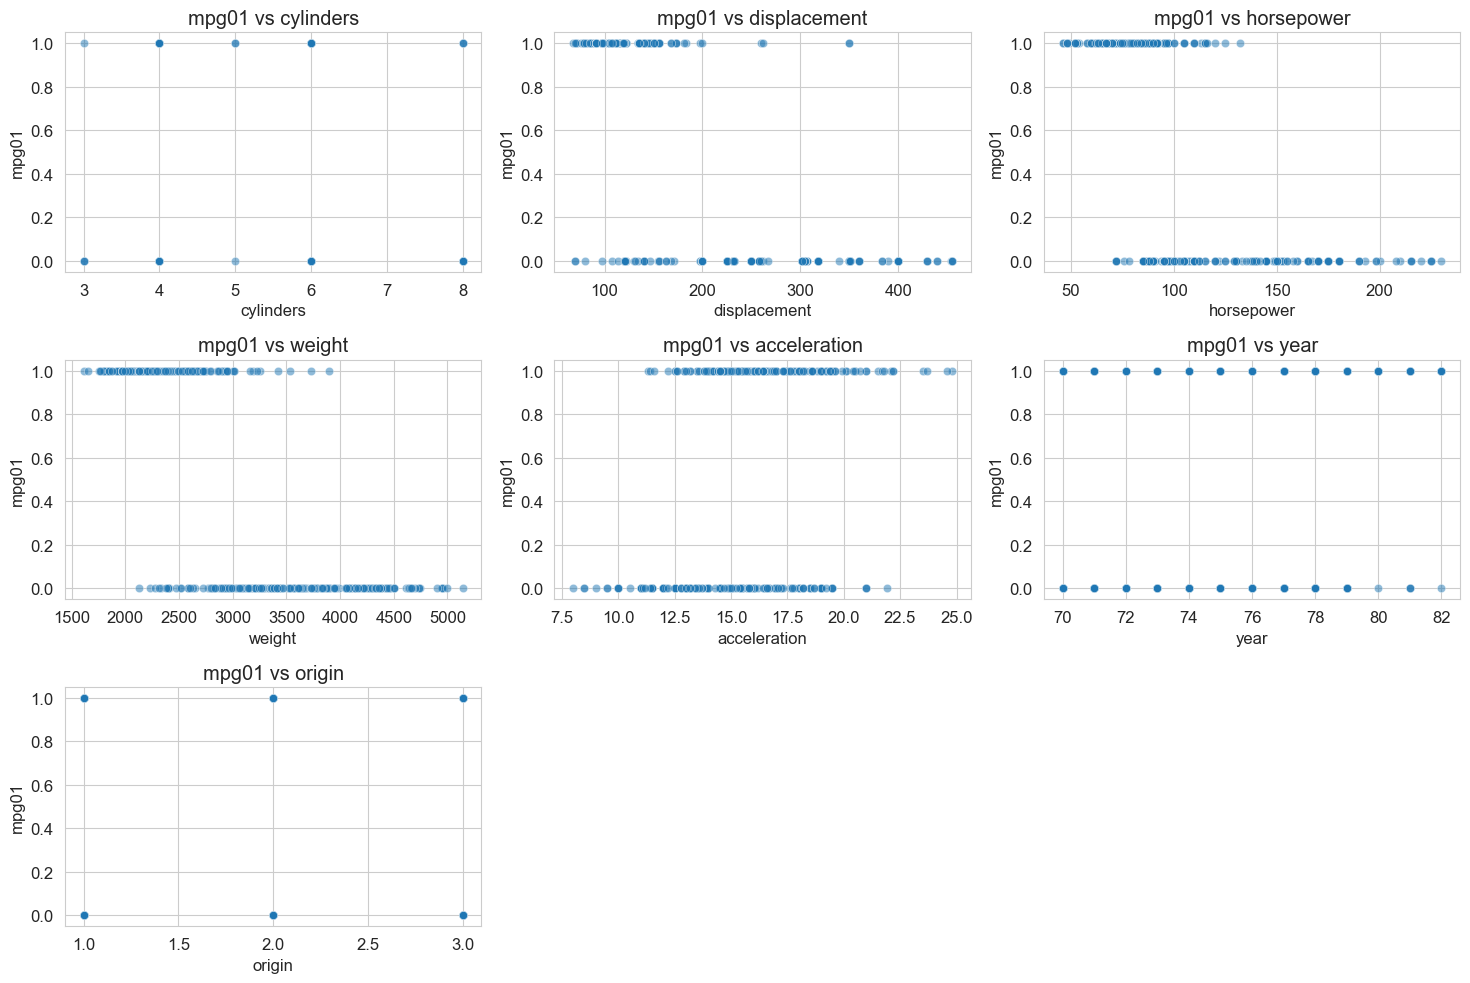

In [20]:
#
#(b)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

features = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    if auto_data[feature].dtype in ['float64', 'int64']:
        sns.scatterplot(data=auto_data, x=feature, y='mpg01', alpha=0.5)
    else:
        sns.boxplot(data=auto_data, x=feature, y='mpg01')
    plt.title(f'mpg01 vs {feature}')

plt.tight_layout()
plt.show()

Features like cylinders, displacement, horsepower, weight, and year appear to be the most useful in predicting mpg01 based on these plots.

In [21]:
#(c)
from sklearn.model_selection import train_test_split

X = auto_data[features]
y = auto_data['mpg01']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((274, 7), (118, 7), (274,), (118,))

Your answer:

~~~
Please write your answer in full sentences.


~~~


(d) Perform LDA on the training data in order to predict `mpg01` using the variables that seemed most associated with `mpg01` in (b). What is the test error of the model obtained?

Your code:

In [22]:
#
#
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

selected_features = ['cylinders', 'displacement', 'horsepower', 'weight', 'year']
lda = LinearDiscriminantAnalysis()

lda.fit(X_train[selected_features], y_train)

y_pred = lda.predict(X_test[selected_features])

test_error = 1 - accuracy_score(y_test, y_pred)
test_error

0.1271186440677966

Your answer:

~~~
The test error is approximately 0.127.
This indicates that the model is able to accurately predict the mpg01 status for about 87.3% of the cars in the test set.


~~~


(e) Perform QDA on the training data in order to predict `mpg01` using the variables that seemed most associated with `mpg01` in (b). What is the test error of the model obtained?

Your code:

In [23]:
#
#
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()

qda.fit(X_train[selected_features], y_train)

y_pred_qda = qda.predict(X_test[selected_features])

test_error_qda = 1 - accuracy_score(y_test, y_pred_qda)
test_error_qda



0.1271186440677966

Your answer:

~~~
The test error obtained from QDA is the same as the test error obtained from the Linear Discriminant Analysis (LDA) model, indicating that both models have similar predictive performance on the test set in this scenario

~~~


(f) Perform logistic regression on the training data in order to predict `mpg01` using the variables that seemed most associated with `mpg01` in (b). What is the test error of the model obtained?

Your code:

In [24]:
#
#
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(X_train[selected_features], y_train)

y_pred_log_reg = log_reg.predict(X_test[selected_features])

test_error_log_reg = 1 - accuracy_score(y_test, y_pred_log_reg)
test_error_log_reg

0.11864406779661019

Your answer:

~~~
The test error is approximately 0.119
This indicates that the Logistic Regression model is able to accurately predict the mpg01 status for about 88.1% of the cars in the test set, making it slightly more accurate than both the LDA and QDA models in this case. ​

~~~


(g) Perform naive Bayes on the training data in order to predict `mpg01` using the variables that seemed most associated with `mpg01` in (b). What is the test error of the model obtained?

Your code:

In [25]:
#
#
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()

naive_bayes.fit(X_train[selected_features], y_train)

y_pred_naive_bayes = naive_bayes.predict(X_test[selected_features])

test_error_naive_bayes = 1 - accuracy_score(y_test, y_pred_naive_bayes)
test_error_naive_bayes


0.1271186440677966

Your answer:

~~~
The test error is approximately 0.127 which is the same as LDA and QDA, and slightly higher than logistic regression.


~~~


(h) Perform KNN on the training data, with several values of K, in order to predict `mpg01`. Use only the variables that seemed most associated with `mpg01` in (b). What test errors do you obtain? Which value of K seems to perform the best on this data set?

Your code:

In [26]:
#
#
from sklearn.neighbors import KNeighborsClassifier

# Range of K values to try
k_values = range(1, 26)

# Dictionary to store test errors for each K
test_errors_knn = {}

# Iterating over different values of K
for k in k_values:
    # KNN model with current K
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fitting the model
    knn.fit(X_train[selected_features], y_train)

    # Predicting on the test data
    y_pred_knn = knn.predict(X_test[selected_features])

    # Calculating and storing the test error
    test_error_knn = 1 - accuracy_score(y_test, y_pred_knn)
    test_errors_knn[k] = test_error_knn

# Identifying the best performing K
best_k = min(test_errors_knn, key=test_errors_knn.get)
best_test_error = test_errors_knn[best_k]

best_k, best_test_error, test_errors_knn


(3,
 0.13559322033898302,
 {1: 0.15254237288135597,
  2: 0.15254237288135597,
  3: 0.13559322033898302,
  4: 0.14406779661016944,
  5: 0.1610169491525424,
  6: 0.15254237288135597,
  7: 0.1694915254237288,
  8: 0.1694915254237288,
  9: 0.1694915254237288,
  10: 0.1694915254237288,
  11: 0.17796610169491522,
  12: 0.17796610169491522,
  13: 0.17796610169491522,
  14: 0.17796610169491522,
  15: 0.17796610169491522,
  16: 0.1694915254237288,
  17: 0.17796610169491522,
  18: 0.1694915254237288,
  19: 0.17796610169491522,
  20: 0.17796610169491522,
  21: 0.17796610169491522,
  22: 0.17796610169491522,
  23: 0.17796610169491522,
  24: 0.1610169491525424,
  25: 0.1610169491525424})

Your answer:

~~~
The best k is 3. which has the test error about 0.136
The test errors vary with different values of K, ranging from around 13.56% to 17.8%.


~~~

## Additional Material

### Classification using ML platforms

Using the COVID Data

#### Classification using sklearn

In [ ]:
# split the data
cols=["MEDICAL_UNIT","PATIENT_TYPE","PNEUMONIA","PREGNANT","DIABETES","COPD","ASTHMA","INMSUPR","HIPERTENSION","OTHER_DISEASE","CARDIOVASCULAR","OBESITY","RENAL_CHRONIC","TOBACCO","CLASIFFICATION_FINAL","FEMALE","AGE_TRUNK"]

# Not recommended, but for now.
Covid_Data_comp = Covid_Data.dropna()
X_train, X_test, y_train, y_test = train_test_split(Covid_Data_comp.loc[:,cols], Covid_Data_comp.loc[:,"SURVIVED"], test_size=0.33, random_state=42)

Train_COVID = pd.concat([X_train, y_train], axis=1)
Test_COVID = pd.concat([X_test, y_test], axis=1)

# Not recommended, but for now.
train_df = Train_COVID.dropna()
test_df= Test_COVID.dropna()

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.predict(X_test)
clf.predict_proba(X_test)

#### Classification using h2o

In [ ]:
# load packages and data
import h2o
localH2O = h2o.init(nthreads = -1, max_mem_size="4g")

Serving the data to H2O

In [ ]:
train_hf = h2o.H2OFrame(train_df)
test_hf = h2o.H2OFrame(test_df)

Model fitting

In [ ]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

logistic_model = H2OGeneralizedLinearEstimator(                               #response variable
                        #predictor variables
                      training_frame = train_hf,                  #data
                      family = "binomial")           #specify the dist. of y and penalty parameter: lambda
logistic_model.train(y = "SURVIVED",x = cols)

prediction=logistic_model.predict(test_hf)

h2o.cluster().shutdown(prompt =False)

## Advanced Content

### Classification

The classification was originally a subject of interest to computer science and, more recently, to machine learning.  In classification, we have a setting similar to a regression. The most significant difference is response $y_i$ is categorical, usually $\{0,1\}$ or $\{-1,1\}$.  The predictors in regression are called features.  Classification aims to learn a model that returns a response class from given accurate features.

For training stage, set of observations $(x_1,y_1),(x_2,y_2),\cdots,(x_n,y_n)\stackrel{iid}{\sim}p(x,y)$ are used to train classifier $f(x)$, similar to estimating $w$ in regression.  And in the testing stage, we observe a set of observations $(x,y)\stackrel{iid}{\sim}p(x,y)$, which come from the same distribution as the training data but are independent of the training dataset.  The hope is the learned $\hat{f}(x)$ is close to $y$, which is similar to prediction in regression.

#### Perceptron

Let's look at a historical classifier called perceptron (1943).  We observe data as

| observation | feature 1 | feature 2 | $\cdots$  | feature p | response |
|:-----------:|:---------:|:---------:|:---------:|:---------:|:--------:|
| 1           | $x_{11}$  | $x_{12}$  | $\cdots$  | $x_{1p}$  | $y_1$    |
| 2           | $x_{21}$  | $x_{22}$  | $\cdots$  | $x_{2p}$  | $y_2$    |
| $\vdots$    | $\vdots$  | $\vdots$  | $\ddots$  | $\vdots$  | $\vdots$ |
| n           | $x_{n1}$  | $x_{n2}$  | $\cdots$  | $x_{np}$  | $y_n$    |
| &nbsp;      | $X_{1}$   | $X_{2}$   | $\cdots$  | $X_{p}$   | $Y$      |

$$
X=\left[
\begin{array}{cccc}
X_{1}&X_{2}&\cdots &X_{p} \\
\end{array}
\right]
\verb|, |
X_i.=\left[1,x_{i1},x_{i2},\cdots,x_{ip}\right]
\verb|, and |
w=\left[
\begin{array}{c}
w_{0} \\
\vdots\\
w_{p} \\
\end{array}
\right]
$$

where $y_i\in \{+1,-1\}$, $\mathbf{x}_{i}$ is the $i$th row of the $X$ matrix concatenated with a vector of 1 with length n on the left side.

The perceptron classifier is defined as
$$f(x)=sgn(w_0+w_1 x_1+\cdots+w_px_p)$$
where $sgn(y)$ is nonlinear transformation defined as
\begin{eqnarray}
sgn(y_i)\left\{
\begin{array}{ll}
+1 & \mbox{ if }y_i\geq 0\\
-1 & \mbox{ if } y_i <0
\end{array}
\right.
\end{eqnarray}

Note that $sgn()$ is a step function that returns one of two values.  If we use 0/1 instead of -1/1 and if we smooth out the transformation function using a sigmoidal function or the inverse logit function, we get logistic regression.

Like any regression, we can define training loss.  The training error is defined as the percentage of misclassified examples.
$$
\frac{1}{n}\sum^n_{i=1}1_{y_i\neq sgn(\mathbf{x}_i\mathbf{w})}
$$
We aim to find weights $w$ so that this function is minimized.  But this loss function is not continuous, nor is it convex.  If you try to calculate the derivative, it's 0 for the most part.  So simple as this problem may seem, you cannot use gradient descent.  Rosenblatt initially used the following iterative algorithm to solve the problem.

1. Choose $w_{(0)}$ at random, choose the learning rate $\eta$
2. For every epoch (iteration) $t$ and sample $i$ update $w_t$ as
$$w_{(t+1)}=w_{(t)} −\eta \Delta w \mathbf{x}_i$$
where
\begin{eqnarray}
\Delta w \left\{
    \begin{array}{l}
    1 \mbox{ if } y_i=1 \mbox{ and } \hat{y}_i= −1\\
    -1 \mbox{ if } y_i  =-1 \mbox{ and } \hat{y}_i=1
    \end{array}
    \right.
\end{eqnarray}

3. Stop when $|w_{(t+1)}−w_{(t)} |<\epsilon$

#### Surrogate loss function

If we can't solve a challenging problem, we can approach it using simple approximation.
Since we know how to take the derivative of squared error loss, we can turn the perceptron problem into a linear regression problem.
$$
\frac{1}{n}\sum^n_{i=1}(y_i - \mathbf{x}_i^T\mathbf{w})^2
$$

which would give us the $\hat{\mathbf{w}}$ that minimizes MSE is our usual LS estimator.
$$\hat{\mathbf{w}}_{MSE}=(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T \mathbf{y}$$
But does it work?  Let's see an example.  Here, we have a simple two-class classification problem using the iris data.  The goal is to find a line that separates the two classes (setosa vs versicolor).  Setosa (blue) and versicolor (red) have distinctive features, so they are well separated by just looking at the petals.

In [ ]:
def make_grid(x, length_out=10):
    rx = np.apply_along_axis(lambda col: [min(col), max(col)], axis=0, arr=x)
    xx = np.array([np.linspace(r[0], r[1], length_out) for r in rx.T])
    xgrid = pd.DataFrame(np.array(np.meshgrid(*xx)).T.reshape(-1, len(xx)), columns=x.columns)
    return xgrid



colnames=["SepalLength", "SepalWidth", "PetalLength","PetalWidth","IrisClass"]
iris = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None,names=colnames)
levels = ["Iris-setosa","Iris-versicolor","Iris-virginica"]
numerals = [-1,1,2]
iris["y"]=iris.iloc[:, 4].replace(levels, numerals)

y = iris.loc[0:99, "y"].astype(int)
x = (iris.loc[0:99, ["PetalLength","PetalWidth"]] - iris.loc[0:99, ["PetalLength","PetalWidth"]].mean()) / iris.loc[0:99, ["PetalLength","PetalWidth"]].std()

xgrid = make_grid(x)

plt.clf()
plt.scatter(x.iloc[:, 0], x.iloc[:, 1], c=np.where(y == 1, 'red', 'blue'), alpha=1)
plt.xlabel(iris.columns[2])
plt.ylabel(iris.columns[3])
plt.title("Iris Setosa vs Versicolor")
plt.show()

# Create a DataFrame for convenience
df = pd.DataFrame({
    'PetalLength': x['PetalLength'],
    'PetalWidth': x['PetalWidth'],
    'y': y
})

We will code the Versicolor as 1 and Setosa as -1.  Given the data, we know how to fit a linear regression model

$$y_i=w_0+w_2\mbox{Petal.Width}_i+w_1\mbox{Petal.Length}_i$$

In [ ]:
# yy = 'y'
# xx = "PetalLength + PetalWidth"
# formula = '%s ~ %s' % (yy, xx)
# fit0 = sm.ols(formula, data=iris).fit()
# print( fit0.summary())

fit0 = LinearRegression().fit(x, y)

cf0 =np.concatenate((np.asarray([fit0.intercept_]),fit0.coef_))

The result defines a surface in 3D space
$$y_i=0+0.25`\mbox{Petal.Width}_i+0.73\mbox{Petal.Length}_i$$
What does the result look like?

In [ ]:
plt.clf()
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['PetalLength'], df['PetalWidth'], df['y'], c=np.where(y == 1, 'red', 'blue'), marker='o', label='Data points')

# Plot the fitted plane
x_plane = np.linspace(df['PetalLength'].min(), df['PetalLength'].max(), 99)
y_plane = np.linspace(df['PetalWidth'].min(), df['PetalWidth'].max(), 100)
X_plane, Y_plane = np.meshgrid(x_plane, y_plane)
Z_plane = cf0[0]+cf0[1] * X_plane + cf0[2] * Y_plane

ax.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.7, color='purple', label='Fitted Plane')

# Set labels and title
ax.set_xlabel('Petal Length')
ax.set_ylabel('Petal Width')
ax.set_zlabel('y')
ax.set_title('3D Scatterplot with Fitted Plane')

plt.show()

In [ ]:
# Scatter plot
scatter = go.Scatter3d(
    x=df['PetalLength'],
    y=df['PetalWidth'],
    z=df['y'],
    mode='markers',
    marker=dict(
        size=5,
        color=np.where(y == 1, 'red', 'blue'),
        opacity=1
    ),
    name='Data points'
)

# Fitted plane
x_plane = np.linspace(df['PetalLength'].min(), df['PetalLength'].max(), 100)
y_plane = np.linspace(df['PetalWidth'].min(), df['PetalWidth'].max(), 100)
X_plane, Y_plane = np.meshgrid(x_plane, y_plane)
Z_plane = cf0[0] + cf0[1] * X_plane + cf0[2] * Y_plane

fitted_plane = go.Surface(
    x=X_plane,
    y=Y_plane,
    z=Z_plane,
    opacity=0.7,
    colorscale='Viridis',
    showscale=False,
    name='Fitted Plane'
)

layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Petal Length'),
        yaxis=dict(title='Petal Width'),
        zaxis=dict(title='y'),
        aspectmode='cube',
        camera=dict(eye=dict(x=1.2, y=1.2, z=1.2))
    ),
    title='3D Scatterplot with Fitted Plane'
)

fig = go.Figure(data=[scatter, fitted_plane], layout=layout)
fig.show()

All the versicolor points are above the plane and all the setosa points are below.

#### separating hyperpane

If we draw into the figure a line that this plane and a plane at 0 intersect, we get a separating hyperplane.
You can get them by solving for $f(x)=0$.  So in terms of Petal Length
$$\mbox{Petal.Width}= - \frac{w_0}{w_2} - \frac{w_1}{w_2} \mbox{Petal.Length}$$

In [ ]:
df = pd.DataFrame({'Petal.Length': x.iloc[:, 0], 'Petal.Width': x.iloc[:, 1], 'y': y})


intercept=-cf0[0] / cf0[2]
slope=-cf0[1] / cf0[2]
abline_values = [ slope * i +  intercept for i in df['Petal.Length']]

plt.clf()

# Plotting the scatter plot
plt.scatter(x.iloc[:, 0], x.iloc[:, 1], c=np.where(y == 1, 'red', 'blue'), alpha=1)
plt.plot(x.iloc[:, 0], abline_values, 'b')
plt.xlabel('Petal.Length')
plt.ylabel('Petal.Width')
plt.title('Iris Setosa vs Versicolor')

plt.show()

The linear model can differentiate binary outcomes.  So why do we need anything else?  The problem is that the loss function does not align with our objective.  If you look at the example below, the green and red points are separated well with a blue line.  Therefore, you are pretty sure any value above 4 is green.  Fitting the regression without one large point (very sure point) gives you the correct decision boundary.  However, with the squared error, larger values play the role of leverage point distorting the decision boundary, which contradicts what we want.  We will return to how we will deal with this later in the semester.  But for now, let's use a loss function that is more suitable for the data.

In [ ]:
xt = np.array([1, 2, 3, 5, 6, 7, 25])
yt = np.array([-1, -1, -1, 1, 1, 1, 1])

# Plot 1
plt.subplot(1, 3, 1)
plt.scatter(xt, yt, c=["red", "red", "red", "green", "green", "green", "green"], cmap='viridis')
plt.ylim(-1,1)
plt.axvline(x=4, color='blue')
plt.title('Original Plot')
plt.xlabel('x')
plt.ylabel('y')

# Plot 2
plt.subplot(1, 3, 2)
plt.scatter(xt, yt, c=["red", "red", "red", "green", "green", "green", "white"])
plt.title('Without Sure Value')
plt.axhline(y=0, linestyle='--', color='grey')
plt.axvline(x=4, color='blue')
plt.ylim(-1,1)
# Fitting a line for x < 10
mask = xt < 10
lm = LinearRegression().fit(xt[mask].reshape(-1, 1), yt[mask])
plt.plot(xt[mask], lm.predict(xt[mask].reshape(-1, 1)), color='grey')

# Plot 3
plt.subplot(1, 3, 3)
plt.scatter(xt, yt, c=["red", "red", "red", "green", "green", "green", "green"])
plt.title('With Sure Value')
plt.axhline(y=0, linestyle='--', color='grey')

# Fitting a line for all data points
lm_all = LinearRegression().fit(xt.reshape(-1, 1), yt)
plt.plot(xt, lm_all.predict(xt.reshape(-1, 1)), color='grey')
plt.axvline(x=-lm_all.intercept_ / lm_all.coef_[0], color='blue')
plt.ylim(-1,1)
plt.tight_layout()
plt.show()

### [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression)

- [Logit function](https://en.wikipedia.org/wiki/Logit) is a mathematical function that transforms a probability ($\pi \in (0,1)$) into log [odds](https://en.wikipedia.org/wiki/Odds)
$$logit(\pi) = \log\left(\frac{\pi}{1-\pi}\right)$$

- Logistic regression is a regression model for binary outcomes $y_i\in \{0,1\}$, $i = 1,\dots n$.  If we let $\pi_i$ be the probability of $y_i=1$, the modeler's interest is understanding what factors affect this probability.  It is similar to linear regression, however, the big distinction is that $\pi_i$ is bounded between 0 and 1.  One can still fit a linear regression model; it’s just that all the estimates will be off beyond the boundaries.
- To avoid such an issue, rather than fitting a linear model on $\pi_i$ we can fit a linear model on $logit(\pi_i)$:
\begin{align}
logit(\pi_i) &= \mathbf{x}_i\boldsymbol{\beta}
\end{align}
because $logit(\pi_i)$ is unbounded, this is a much better transformation for applying a linear model.

- We can also denote the model using the inverse logit function as a nonlinear model on the probability of success $\pi_i$:
$$P(y_i=1|\mathbf{x}_i) = \pi_i= logit^{-1}(\mathbf{x}_i\boldsymbol{\beta})=\frac{e^{\mathbf{x}_i\boldsymbol{\beta}}}{1+e^{\mathbf{x}_i\boldsymbol{\beta}}}=\frac{1}{1+e^{-\mathbf{x}_i\boldsymbol{\beta}}}$$

- Logistic regression coefficient $\boldsymbol{\beta}$ is often estimated using Maximum Likelihood.

----

#### Likelihood

- For a binary outcome, the natural choice of a probability distribution is the Bernoulli distribution.
\begin{align}
y_i &= Bernoulli(\pi_i)
\end{align}

- The likelihood for observation $i$ is defined as
$$f(y_i | \mathbf{x}_i,\boldsymbol{\beta})= \pi_i^{y_i} (1-\pi_i)^{(1-y_i)}$$ where
$$\pi_i=logit^{-1}(\mathbf{x}_i\boldsymbol{\beta})=\frac{\exp(\mathbf{x}_i\boldsymbol{\beta})}{1+\exp(\mathbf{x}_i\boldsymbol{\beta})}$$
- The log-likelihood is
\begin{align}
\log(f(y_i|\boldsymbol{\beta}))&=\log\left(\pi_i^{y_i} (1-\pi_i)^{(1-y_i)}\right)\\
&= \log\left(\pi_i^{y_i}\right)+\log\left( (1-\pi_i)^{(1-y_i)}\right)\\
&= y_i\log(\pi_i)+(1-y_i)\log( 1-\pi_i)\\
&= y_i\log\pi_i - y_i\log(1-\pi_i) +\log(1-\pi_i)
\end{align}


----

#### Joint log-likelihood

- Assuming the observations are iid the joint log-likelihood for $n$ observations is a product of the individual likelihoods, which is the sum of the log-likelihoods.
\begin{align}
l(\boldsymbol{\beta};\mathbf{y})&= \sum_i( y_i\log\pi_i - y_i\log(1-\pi_i) +\log(1-\pi_i))\\
&=\sum_i^N\left( y_i(\log\pi_i-\log(1-\pi_i)) + \log(1-\pi_i)\right)\\
&=\sum_i^N\left( y_i\left(\log\left(\frac{\pi_i}{\log(1-\pi_i)}\right)\right) + \log(1-\pi_i)\right)\\
&=\sum_i^N\left( y_i\left(\mathbf{x}_i\boldsymbol{\beta}\right) + \log\left(\frac{1}{1+\exp(\mathbf{x}_i\boldsymbol{\beta})}\right)\right)\\
&=\sum_i^N\left( y_i(\mathbf{x}_i\boldsymbol{\beta}) - \log\left(1+\exp\left(\mathbf{x}_i\boldsymbol{\beta}\right)\right)\right)\\
\end{align}

----

#### Model fitting

#### Calculating the first and second moments

- If we calculate the score function for $\beta_k$ by taking the derivative of the joint log-likelihood wrt $\beta_k$
\begin{align}
s_k(\boldsymbol{\beta})=\frac{\partial l(\boldsymbol{\beta};\mathbf{y})}{\partial \beta_k}&=\frac{\partial }{\partial \beta_k}\sum_i^N( y_i(\mathbf{x}_i\boldsymbol{\beta}) - \log(1+\exp(\mathbf{x}_i\boldsymbol{\beta})))\\
&=\sum_i^N \left( y_i x_{ik} - \frac{\exp(\mathbf{x}_i\boldsymbol{\beta})}{(1+\exp(\mathbf{x}_i\boldsymbol{\beta}))}x_{ik}\right)\\
&=\sum_i^N ( y_i x_{ik} - \pi_ix_{ik})=\sum_i^N x_{ik}( y_i  - \pi_i)\\
\end{align}
We can collect this into a vector
\begin{align}
s(\boldsymbol{\beta})=\left[
\begin{array}{c}
s_1(\boldsymbol{\beta})\\
s_2(\boldsymbol{\beta})\\
\vdots\\
s_p(\boldsymbol{\beta})
\end{array}
\right]=
\left[
\begin{array}{c}
\sum_i^N x_{i1}( y_i  - \pi_i)\\
\sum_i^N x_{i2}( y_i  - \pi_i)\\
\vdots\\
\sum_i^N x_{ip}( y_i  - \pi_i)
\end{array}
\right]=\sum_i^N \mathbf{x}_{i}( y_i  - \pi_i)=\sum_i^N s(\boldsymbol{\beta})_i
\end{align}
- Noting that $E(s(\boldsymbol{\beta})_i)=\mathbf{0}$ we can calculate the expected Fisher Information for observation $i$ as
$$F(\boldsymbol{\beta})_i=Cov(s(\boldsymbol{\beta})_i)=E(s(\boldsymbol{\beta})_is(\boldsymbol{\beta})_i^T)$$
\begin{align}
E(s(\boldsymbol{\beta})_is(\boldsymbol{\beta})_i^T)&=E\left(\mathbf{x}_{i}( y_i  - \pi_i)(\mathbf{x}_{i}( y_i  - \pi_i))^T\right)\\
&=E\left(\mathbf{x}_{i}\mathbf{x}_{i}^T( y_i  - \pi_i)^2\right)\\
&=\mathbf{x}_{i}\mathbf{x}_{i}^T E\left(( y_i  - \pi_i)^2\right)\\
&=\mathbf{x}_{i}\mathbf{x}_{i}^T Var\left( y_i\right)\\
&=\mathbf{x}_{i}\mathbf{x}_{i}^T \pi_i(1-\pi_i)
\end{align}
The Fisher Information for all $n$ observations is
$$F(\boldsymbol{\beta})=\sum_i^nF(\boldsymbol{\beta})_i=\sum_i^n\mathbf{x}_{i}\mathbf{x}_{i}^T \pi_i(1-\pi_i)$$
<!-- \frac{\partial^2 l(\boldsymbol{\beta};\mathbf{y})}{\partial \beta_{k} \partial \beta_{k'}}  -->
<!-- &=-\sum_i^N \left( \frac{\exp(\mathbf{x}_i\boldsymbol{\beta})}{(1+\exp(\mathbf{x}_i\boldsymbol{\beta}))}\right)\\ -->
<!-- &=-\sum_i^N (x_{ik} \pi_i(1-\pi_i) x_{ik'})\\ -->
- We will not show it here, but the observed and the expected Fisher Information coincides for the logistic regression model.  This is not true in general.
- We can also collect the terms into a matrix by using
$$\mathbf{y}
=
\left[
\begin{array}{c}
y_{1}\\
y_{2}\\
\vdots\\
y_n
\end{array}
\right]\mbox{, }
\boldsymbol{\mu}=\left[
\begin{array}{c}
\pi_{1}\\
\pi_{2}\\
\vdots\\
\pi_n
\end{array}
\right]\mbox{, }
\mathbf{X}
=
\left[
\begin{array}{c}
\mathbf{x}_{1}^T\\
\mathbf{x}_{2}^T\\
\vdots\\
\mathbf{x}_{n}^T
\end{array}
\right]\mbox{, }
\mathbf{W}
=
\left[
\begin{array}{ccc}
\pi_{1}(1-\pi_{1})&\cdots&&0\\
0&\pi_{2}(1-\pi_{2})&\cdots&0\\
\vdots&\ddots&&\vdots\\
0&\cdots&&\pi_{n}(1-\pi_{n})
\end{array}
\right]$$
We can express the score function as
$$
s(\boldsymbol{\beta})=\sum_i^N \mathbf{x}_{i}( y_i  - \pi_i)= \mathbf{X}^T( \mathbf{y}  - \boldsymbol{\mu})
$$
and the Fisher Information as
$$F(\boldsymbol{\beta})=\sum_i^n\mathbf{x}_{i}\mathbf{x}_{i}^T \pi_i(1-\pi_i)=\mathbf{X}^T\mathbf{W}\mathbf{X}$$
<!-- - The critical value will be maximum if this matrix is negative definite. -->
<!-- - Also, this forms a variance covariance matrix of the parameter estimates. -->

- We use the Newton–Raphson or Fisher scoring algorithm to get the maximum likelihood.


----

#### Newton-Raphson Method for logistic regression

- The details of the Newton-Raphson method for finding the maximum likelihood are as follows.

1. You start with a guess of the parameters $\boldsymbol{\beta}^{(0)}$.
2. With every iteration $t$ update
$$
\boldsymbol{\beta}^{(t+1)}=\boldsymbol{\beta}^{(t)}+\left[F\left(\boldsymbol{\beta}^{(t)}\right)\right]^{-1}s\left(\boldsymbol{\beta}^{(t)}\right)
$$

- If we substitute in
$$s(\boldsymbol{\beta})=\mathbf{X}^{T}(\mathbf{y}-\boldsymbol{\mu})$$
where $\boldsymbol{\mu}$ be vector where $\mu_i = \pi_i$
- And
$$F(\boldsymbol{\beta})=-\mathbf{X}^{T}\mathbf{W}\mathbf{X}$$
where $\mathbf{W}$ be a diagonal matrix where $w_{ii} = \pi_i(1-\pi_i)$.

- Therefore, the coefficient estimates at iteration $t$, $\boldsymbol{\beta}^{(t)}$ is updated to $\boldsymbol{\beta}^{(t+1)}$ using the following formula:
$$
\boldsymbol{\beta}^{(t+1)}=\boldsymbol{\beta}^{(t)}+[\mathbf{X}^{T}\mathbf{W}^{(t)}\mathbf{X}]^{-1}\mathbf{X}^{T}(\mathbf{y}-\boldsymbol{\mu}^{(t)})
$$
note here that $\boldsymbol{\mu}^{(t)}$ and $\mathbf{W}^{(t)}$ changes with the state of $\boldsymbol{\beta}^{(t)}$.


----

#### Newton-Raphson using R

- The Newton-Raphson algorithm for logistic regression can be implemented using just a couple of lines of code.

In [ ]:
def NewtonRaphson(y, desmat, beta_init_guess, maxiter=20):
    beta_guess = np.empty((2, maxiter+1))
    beta_guess[:, 0] = beta_init_guess

    for i in range(1, maxiter+1):
        pi_guess = expit(np.dot(desmat, beta_guess[:, i-1]))
        wii = pi_guess * (1 - pi_guess)
        lb = np.dot(desmat.T, y - pi_guess)
        llbinv = np.linalg.solve(np.dot(np.dot(desmat.T, np.diag(wii)), desmat), np.eye(2))
        beta_guess[:, i] = beta_guess[:, i-1] + np.dot(llbinv, lb)

    return beta_guess

In [ ]:
# Generate fake data
x = np.random.normal(size=1000)
y = np.random.binomial(1, p=1 / (1 + np.exp(-1 * (1 + x * 3))), size=1000)
desmat = np.column_stack((np.ones_like(x), x))

# Run the algorithm
beta_guess=NewtonRaphson(y,desmat,beta_init_guess=[0.1,0.1])

- Below, each point is an estimate at a particular iteration.

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot([1, 20], [0, 4], 'k--', alpha=0,color='red')

plt.plot(range(1, 22), beta_guess[1, :], alpha=0.3, color='black')

plt.axhline(y = 3, color = 'r', linestyle = '--',label='True Beta')
plt.xlabel('Iteration')
plt.ylabel('Beta')
plt.legend()
plt.show()

As you can see, the algorithm starts from a guess and quickly approaches the actual value, which is expressed using a dashed horizontal red line.

- We can generate the data many times and run the algorithm repeatedly.  Below, we plot the trace of each algorithm.  Notice there that there is variability in the estimate due to sampling.

In [ ]:
np.random.seed(123)
kk = 20
beta_guess_list = []

niter = 19
for k in range(1, kk + 1):
    x = np.random.normal(size=1000)
    y = np.random.binomial(1, p=1 / (1 + np.exp(-1 * (1 + x * 3))), size=1000)

    beta_guess = np.zeros((2, niter + 1))
    beta_guess[:, 0] = [0.1, 0.1]
    desmat = np.column_stack((np.ones_like(x), x))

    for i in range(1, niter + 1):
        pi_guess = 1 / (1 + np.exp(-np.dot(desmat, beta_guess[:, i-1])))
        wii = pi_guess * (1 - pi_guess)
        lb = np.dot(desmat.T, y - pi_guess)
        llbinv =np.linalg.solve( np.dot(np.dot(desmat.T, np.diag(wii)), desmat), np.eye(2))
        beta_guess[:, i] = beta_guess[:, i - 1] + np.dot(llbinv, lb)

    beta_guess_list.append(beta_guess)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot([1, 20], [0, 4], 'k--', alpha=0,color='red')

for k in range(kk):
    plt.plot(range(1, niter + 2), beta_guess_list[k][1, :], alpha=0.3, color='black')

plt.axhline(y = 3, color = 'r', linestyle = '--',label='True Beta')
plt.xlabel('Iteration')
plt.ylabel('Beta')
plt.legend()
plt.show()

#### Generative vs discriminative

Notice that this likelihood $\prod^n_{i=1}f(y_i=1\mid \mathbf{x}_i,\boldsymbol{\beta})$ is a likelihood WRT $\mathbf{y}$ which ignores $\mathbf{X}$s (or treats it as given) thus it is termed partial-likelihood.  In discriminative studies where the study focuses on the model's performance on tasks such as classification, this is the objective being used.

On the other hand, where interest is understanding the mechanism that generated the data, we need a generative model where the interest is on modeling the full-likelihood as $\prod^n_{i=1}f(y_i=1,\mathbf{x}_i\mid \boldsymbol{\beta})$.
Notice full likelihood can be factored as
$$
\prod^n_{i=1}f(y_i=1,\mathbf{x}_i\mid \boldsymbol{\beta})=\prod^n_{i=1}f(\mathbf{x}_i\mid \boldsymbol{\beta})f(y_i=1\mid \mathbf{x}_i,\boldsymbol{\beta})
$$
which is the partial-likelihood used in logistic regression  $\prod^n_{i=1}f(y_i=1\mid \mathbf{x}_i,\boldsymbol{\beta})$ times $f(\mathbf{x}_i\mid \boldsymbol{\beta})$ term.  This term can be thought of as observed data likelihood.  If there is information about $\boldsymbol{\beta}$ in the observed data, ignoring this term results in a loss of information.  Alternatively, if we factor the full likelihood as a generative model
$$
\prod^n_{i=1}p(y_i=1,\mathbf{x}_i\mid \boldsymbol{\beta})=\prod^n_{i=1}p(y_i=1\mid \boldsymbol{\beta})p(\mathbf{x}_i\mid y_i,\boldsymbol{\beta})
$$
Then you can think of $p(y_i=1\mid \boldsymbol{\beta})$ term as the prior distribution similar to Naive Bayes.

The likelihood $f(\mathbf{x}_i\mid y_i,\boldsymbol{\beta})$ can be partitioned into two
  \begin{eqnarray}
  f(\mathbf{x}_i\mid y_i,\beta)\left\{
    \begin{array}{l}
    f(\mathbf{x}_i\mid y_i=1,\beta)=p_{+}(X)\\
    f(\mathbf{x}_i\mid y_i=0,\beta)=p_{-}(X)
    \end{array}
    \right.
\end{eqnarray}

$$
logit(\pi_i) = log\frac{f(y_i=1\mid \mathbf{x}_i, \boldsymbol{\beta})}{f(y_i=0\mid \mathbf{x}_i, \boldsymbol{\beta})}=log \frac{f(\mathbf{x}_i\mid y_i=1,\boldsymbol{\beta})f(y_i=1\mid \boldsymbol{\beta})}{f(\mathbf{x}_i\mid y_i=0,\boldsymbol{\beta})f(y_i=0\mid  \boldsymbol{\beta})}
$$
In logistic regression with a threshold of 0.5, we predict the outcome to be 1 if this quantity is positive.  In naive Bayes with two classes, we predict 1 when the right-hand side ratio exceeds 1. You can work out the details to show how they connect. Logistic regression and naive Bayes / normal discriminant analysis are referred to as a generative-discriminative pair. The predictive performances are comparable and depend on the data and how closely they match the model's assumptions. You can read more about it in Ng & Jordan (2002).